# Imports #

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split

2024-12-06 13:53:46.085917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# EDA #

In [2]:
train_labels = pd.read_csv("./data/train_images.csv")
test_samples = pd.read_csv("./data/test_images_sample.csv")

class_names = np.load("data/class_names.npy", allow_pickle=True).item()

#print(train_labels.head())

for bird in list(class_names.keys()):
    print(bird)

001.Black_footed_Albatross
002.Laysan_Albatross
003.Sooty_Albatross
004.Groove_billed_Ani
005.Crested_Auklet
006.Least_Auklet
007.Parakeet_Auklet
008.Rhinoceros_Auklet
009.Brewer_Blackbird
010.Red_winged_Blackbird
011.Rusty_Blackbird
012.Yellow_headed_Blackbird
013.Bobolink
014.Indigo_Bunting
015.Lazuli_Bunting
016.Painted_Bunting
017.Cardinal
018.Spotted_Catbird
019.Gray_Catbird
020.Yellow_breasted_Chat
021.Eastern_Towhee
022.Chuck_will_Widow
023.Brandt_Cormorant
024.Red_faced_Cormorant
025.Pelagic_Cormorant
026.Bronzed_Cowbird
027.Shiny_Cowbird
028.Brown_Creeper
029.American_Crow
030.Fish_Crow
031.Black_billed_Cuckoo
032.Mangrove_Cuckoo
033.Yellow_billed_Cuckoo
034.Gray_crowned_Rosy_Finch
035.Purple_Finch
036.Northern_Flicker
037.Acadian_Flycatcher
038.Great_Crested_Flycatcher
039.Least_Flycatcher
040.Olive_sided_Flycatcher
041.Scissor_tailed_Flycatcher
042.Vermilion_Flycatcher
043.Yellow_bellied_Flycatcher
044.Frigatebird
045.Northern_Fulmar
046.Gadwall
047.American_Goldfinch
048.Eu

In [3]:
train_labels.sample(20)

,image_path,label
552,/train_images/553.jpg,19
873,/train_images/874.jpg,29
1684,/train_images/1685.jpg,58
3617,/train_images/3618.jpg,161
1387,/train_images/1388.jpg,47
32,/train_images/33.jpg,1
1800,/train_images/1801.jpg,62
3828,/train_images/3829.jpg,185
1519,/train_images/1520.jpg,52
2697,/train_images/2698.jpg,101


In [4]:
print(train_labels["label"].value_counts())

# Count of each class goes from 5 to 35
print("Min amount of times a class appears:", (train_labels["label"].value_counts()).min())
print("Max amount of times a class appears:", (train_labels["label"].value_counts()).max())

label
1      35
4      35
2      35
9      34
10     34
       ..
196     6
197     5
198     5
199     5
200     5
Name: count, Length: 200, dtype: int64
Min amount of times a class appears: 5
Max amount of times a class appears: 35


I decided to add a new column, `class_labels`, with the categorical name of each label so it was easier to visualise and have a better idea on which birds had the higher number of occurrences.

In [5]:
train_labels['class_name'] = train_labels['label'].map(
    {v: k for k, v in class_names.items()}  # Reverse the dictionary to map label to class_name
)

train_labels['class_name'] = [
    "_".join(name.split('.')[1].split('_')) for name in train_labels['class_name']
]

train_labels['image_path'] = 'data' + train_labels['image_path']
train_labels

,image_path,label,class_name
0,data/train_images/1.jpg,1,Black_footed_Albatross
1,data/train_images/2.jpg,1,Black_footed_Albatross
2,data/train_images/3.jpg,1,Black_footed_Albatross
3,data/train_images/4.jpg,1,Black_footed_Albatross
4,data/train_images/5.jpg,1,Black_footed_Albatross
...,...,...,...
3921,data/train_images/3922.jpg,200,Common_Yellowthroat
3922,data/train_images/3923.jpg,200,Common_Yellowthroat
3923,data/train_images/3924.jpg,200,Common_Yellowthroat
3924,data/train_images/3925.jpg,200,Common_Yellowthroat


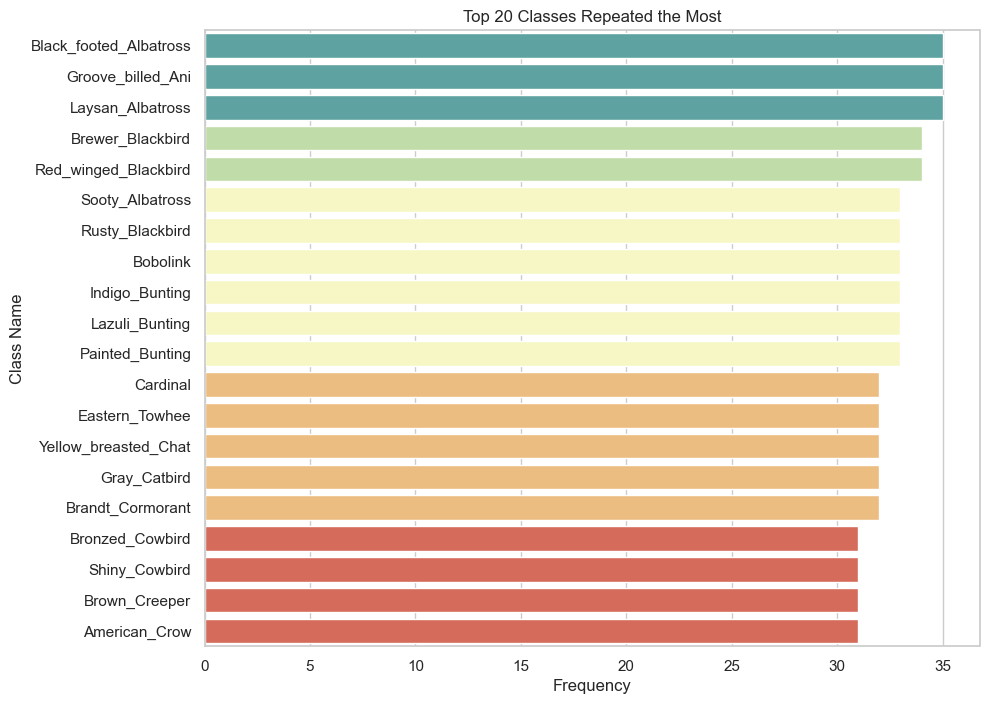

In [6]:
# Let's check beautifully which are the top 20 most repeated bird classes
top_20 = (train_labels['class_name'].value_counts()[:20])

color_palette = sns.color_palette("Spectral", len(set(top_20.values)))
frequency_to_color = {freq: color for freq, color in zip(sorted(set(top_20.values)), color_palette)}
bar_colors = [frequency_to_color[freq] for freq in top_20.values]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.barplot(
    x=top_20.values,
    y=top_20.index,
    palette=bar_colors
)
plt.xlabel("Frequency")
plt.ylabel("Class Name")
plt.title("Top 20 Classes Repeated the Most")
plt.show()

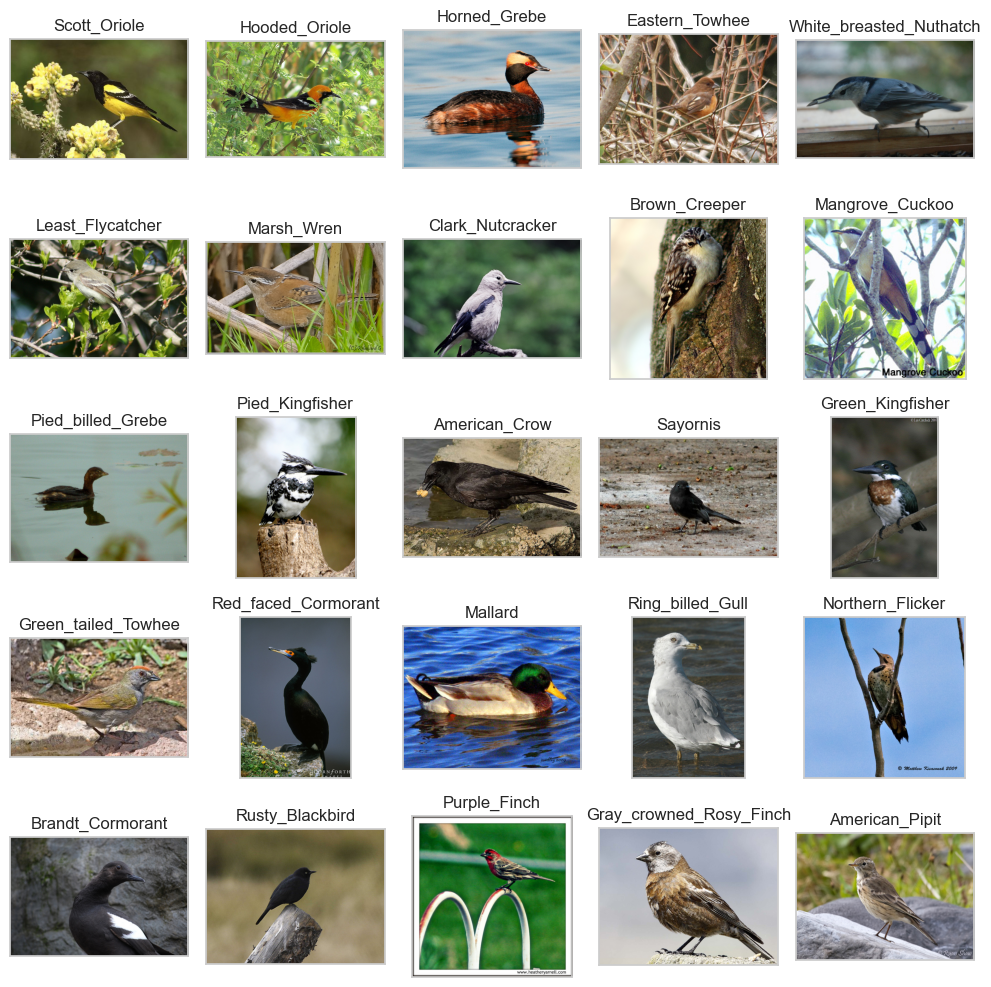

In [7]:
sample_df = train_labels.sample(25)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), 
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (_, row) in zip(axes.flat, sample_df.iterrows()):
    ax.imshow(plt.imread(row['image_path']))
    ax.set_title(row['class_name'])

plt.tight_layout()
plt.show()

# Data Processing #

Decided to add a small validation set, 20% of the training set since the size of the test_images folder is 4000 images.
I am still quite confused about this, so we might need to properly check this out 

In [8]:
# train_df, test_df = train_test_split(train_labels, test_size=0.2, shuffle=True, random_state=42)

image_paths = train_labels['image_path'].values
labels = train_labels['label'].values

# 80% train, 20% validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

Lil explanation on what all this is and why we decided to include it:

****Resizing and normalizing the pixels****:\
*****Resizing:***** NNs require that the input data is the same shape to efficiently batch and process data. Using a consistent image size ensures that convolution layers have a consistent input, leading to more reliable results and easier model design.\
*****Normalization:***** Scaling pixel values helps the model converge faster during training because smaller values ensure the gradients are more stable. Normalizing the pixel values ensures that different images have a comparable range, which helps the model learn effectively across diverse data.

****Augmentation****:\
Data Augmentation introduces random changes to the images, such as flipping, rotating, or adjusting brightness. This is done to artificially expand the dataset and make the model more robust to variations. We later can include more augemntations to improve the robustness, for now I just included those but we can discuss on others, like zooming (didnt include it cuz it was a randome value from our friend ChatGPT)

In [9]:
def resize_normalize(image_path, label):
    # loading image
    image = tf.io.read_file(image_path)
    # jpg image to tensor so that it can be processed by TensorFlow
    image = tf.image.decode_jpeg(image, channels=3)
    # resizing all images for further processing
    image = tf.image.resize(image, [224, 224])
    # pixel normalisation for reproducibility and learning general patterns
    image = image / 255.0

    return image, label

def augmentation(image, label):
    # horizontal flip
    image = tf.image.random_flip_left_right(image)
    # brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2) 
    # contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  
    # zooming (?)
    # image = tf.image.random_zoom(image, [0.9, 1.1])

    return image, label

We do not include `augmentation` in the validation or test sets since data augmentation is primarily used to help the model learn better by adding variability during training, rather than during evaluation. Augmentation during testing would not add any meaningful information, sometimes it can also add randomness to it that would mess with the predictions later on.

In [10]:
# training dataset with resizing, normalization, and augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(resize_normalize, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# validation dataset with resizing and normalization (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(resize_normalize, num_parallel_calls=tf.data.AUTOTUNE)

Now, what is all this mess:
****Batch, shuffle and prefetch****\
*****Shuffle:***** Only introduced in the training data, it makes sure that the model does not learn the data in sequences that can affect the predictions, and rather learns the data as a whole. It helps to prevent overfitting.\
*****Batch:***** It groups consecutive elements of the dataset into batches. Instead of processing one example at a time, the model will be trained on batches of data to imporove comutational efficiency. Batching the validation data helps process multiple images together. Batching is applied during evaluation to speed up calculations of metrics like accuracy and loss.\
*****Prefetch:***** Prefetching ensures that while the model is training on the current batch, the next batch is being loaded and preprocessed in the background.

(The `tf.data.AUTOTUNE` automatically determines the best number of batches to prefetch based on the system, helps improve efficiency)

In [11]:
# Batch, shuffle and prefetch datasets
batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
test_images_path = pd.read_csv('./data/test_images_path.csv')
test_paths = test_images_path['image_path'].apply(lambda x: 'data' + x).values

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, [-1] * len(test_paths)))
test_dataset = test_dataset.map(resize_normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
# Now we get the length based on the batches
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print("\n")

print("train:", train_dataset)
print("validation:", val_dataset)
print("test:", test_dataset)

99
25
125


train: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [14]:
def summarize_dataset(df, name):
    labels = []
    for _, label in df:
        label = np.array(label)
        labels.extend(label.flatten())

    if labels:
        label_series = pd.Series(labels)
        label_counts = label_series.value_counts()
        num_classes = len(label_counts)
        df_size = label_series.shape[0]

        print(f"Found {df_size} image filenames from {num_classes} classes in {name}.")

summarize_dataset(train_dataset, "training dataset")
summarize_dataset(val_dataset, "validation dataset")

test_size = test_dataset.cardinality().numpy()
print(f"Found {test_size} image filenames from Dummy labeled classes in test dataset.")

Found 3140 image filenames from 200 classes in training dataset.
Found 786 image filenames from 200 classes in validation dataset.
Found 125 image filenames from Dummy labeled classes in test dataset.


In [15]:
def images_with_batches(dataset, name):
    total_images = sum(1 for _ in dataset.unbatch())

    num_batches = dataset.cardinality().numpy()
    print(f"Dataset: {name}")
    print(f"Total number of images: {total_images}")
    print(f"Number of batches: {num_batches}\n")

images_with_batches(train_dataset, "Training Dataset")
images_with_batches(val_dataset, "Validation Dataset")
images_with_batches(test_dataset, "Test Dataset")

Dataset: Training Dataset
Total number of images: 3140
Number of batches: 99

Dataset: Validation Dataset
Total number of images: 786
Number of batches: 25

Dataset: Test Dataset
Total number of images: 4000
Number of batches: 125

